In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tscv_sliding
from window_generator import WindowGenerator

In [43]:
from fredapi import Fred
fred_api_key = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=fred_api_key)
start_date = "2003-01-02" 
end_date = "2022-12-30"

In [44]:
vix = fred.get_series("VIXCLS", observation_start=start_date, observation_end=end_date).to_frame()
vix.head()

,0
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53


In [45]:
vix.rename(columns={0:"VIX"}, inplace=True)
vix

,VIX
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53
...,...
2022-12-26,NaN
2022-12-27,21.65
2022-12-28,22.14
2022-12-29,21.44


In [46]:
vix.fillna(method="ffill", inplace=True)

In [47]:
vix['VIX_bin'] = np.where(vix.diff() > 0, 1, 0)
vix.head()

,VIX,VIX_bin
2003-01-02,25.39,0
2003-01-03,24.68,0
2003-01-06,24.91,1
2003-01-07,25.13,1
2003-01-08,25.53,1


In [48]:
n = len(vix)
n_train = int(n*0.7)
n_val = int(n*0.9)
train_df = vix[0:n_train]
val_df = vix[n_train:n_val]
test_df = vix[n_val:]

In [49]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3651, 2)
(1044, 2)
(522, 2)


In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cols = train_df.columns
train_indices = train_df.index
val_indices = val_df.index
test_indices = test_df.index

scale = MinMaxScaler()
train_df = scale.fit_transform(train_df)
val_df = scale.transform(val_df)
test_df = scale.transform(test_df)

train_df = pd.DataFrame(train_df, columns=cols, index=train_indices)
val_df = pd.DataFrame(val_df, columns=cols, index=val_indices)
test_df = pd.DataFrame(test_df, columns=cols, index=test_indices)
train_df.head()

,VIX,VIX_bin
2003-01-02,0.218402,0.0
2003-01-03,0.208398,0.0
2003-01-06,0.211639,1.0
2003-01-07,0.214739,1.0
2003-01-08,0.220375,1.0


In [51]:
input_width = 30

In [61]:
from sklearn.preprocessing import RobustScaler
w = WindowGenerator(input_width=input_width, 
                    label_width=1,
                    label_columns=['VIX_bin'],
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=5,
                    train_splits=3,
                    test_splits=1)

In [62]:
w.train.element_spec

(TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [176]:
def build_model():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 2))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(Dense(1, activation="sigmoid"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ['binary_crossentropy']
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model

In [177]:
MAX_EPOCHS = 200
model = build_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [178]:
history = model.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/200


2023-05-11 14:59:06.486191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:06.915888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:07.054634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:07.165963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:07.439715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:07.637205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 14:59:07.842128: I tensorflow/core/grappler/optimizers/cust

KeyboardInterrupt: 

In [ ]:
x = np.concatenate([x for x, y in w.test], axis = 0)
y = np.concatenate([y for x, y in w.test], axis = 0)
predicted = model.predict(x)
preds = predicted
predicted = np.where(predicted > 0.5, 1, 0)
y = y.reshape((y.shape[0], 1))

16/16 [==============================] - 0s 15ms/step


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, predicted))

0.5691056910569106


Bayesian Model

In [188]:
import tensorflow_probability as tfp
tfd = tfp.distributions

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

n_samples = np.concatenate([x for x, y in w.train], axis=0).shape[0]

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [208]:
def build_bnn():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 2))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/n_samples, activation="sigmoid"))
    #model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ['binary_crossentropy']
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model


In [209]:
bnn = build_bnn()
bnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 30, 32)            4480      
                                                                 
 lstm_61 (LSTM)              (None, 30, 96)            49536     
                                                                 
 lstm_62 (LSTM)              (None, 64)                41216     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_variational_5 (DenseV  (None, 1)                195       
 ariational)                                                     
                                                                 
Total params: 95,427
Trainable params: 95,427
Non-trainable params: 0
_________________________________________________

In [250]:
MAX_EPOCHS = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [251]:
history = bnn.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/20
114/114 [==============================] - 5s 47ms/step - loss: 0.6844 - binary_crossentropy: 0.6836 - val_loss: 0.6864 - val_binary_crossentropy: 0.6856
Epoch 2/20
114/114 [==============================] - 5s 45ms/step - loss: 0.6858 - binary_crossentropy: 0.6850 - val_loss: 0.6828 - val_binary_crossentropy: 0.6820
Epoch 3/20
114/114 [==============================] - 5s 44ms/step - loss: 0.6838 - binary_crossentropy: 0.6830 - val_loss: 0.6835 - val_binary_crossentropy: 0.6826
Epoch 4/20
114/114 [==============================] - 5s 44ms/step - loss: 0.6844 - binary_crossentropy: 0.6836 - val_loss: 0.6805 - val_binary_crossentropy: 0.6796
Epoch 5/20
114/114 [==============================] - 5s 45ms/step - loss: 0.6834 - binary_crossentropy: 0.6826 - val_loss: 0.6879 - val_binary_crossentropy: 0.6870
Epoch 6/20
114/114 [==============================] - 5s 44ms/step - loss: 0.6839 - binary_crossentropy: 0.6830 - val_loss: 0.6807 - val_binary_crossentropy: 0.6799
Epoch 7/20

In [337]:
b_x = np.concatenate([x for x, y in w.val], axis = 0)
b_y = np.concatenate([y for x, y in w.val], axis = 0)

ensemble = []

for i in range(100):
    ensemble.append(bnn(b_x))

mean = np.mean(ensemble, axis = 0)
std = np.std(ensemble, axis = 0)

predicted = np.where(mean > 0.444, 1, 0)

In [338]:
print(np.median(mean))

0.45224947


In [339]:
print(accuracy_score(b_y.flatten(), predicted))

0.5483234714003945


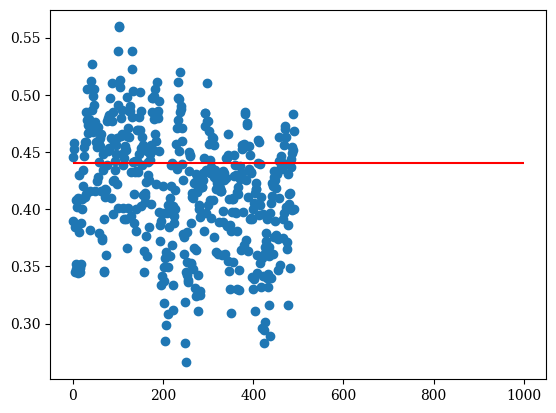

In [397]:
plt.scatter(np.arange(len(predicted)), mean)
plt.hlines(0.44, xmin=0, xmax=1000, color ='red')

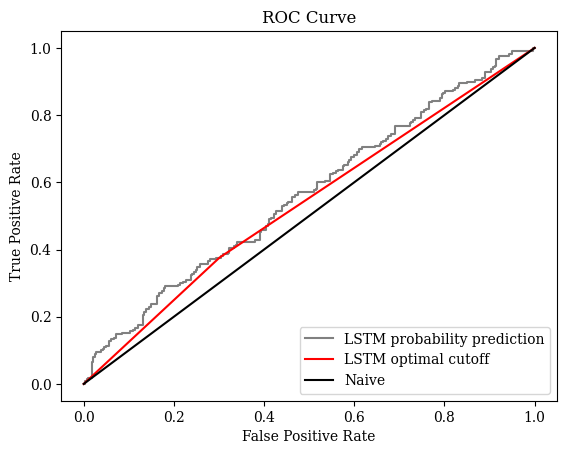

In [398]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(b_y.flatten(), mean)


fig, ax = plt.subplots()

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'Grey', ax=ax, label = 'LSTM probability prediction')
fpr, tpr, thresholds = roc_curve(b_y.flatten(), predicted)
roc_display2 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'Red', ax=ax, label = 'LSTM optimal cutoff')
cutoffs = np.linspace(0, 1, 100)
roc_display3 = RocCurveDisplay(fpr=cutoffs, tpr=cutoffs).plot(color = 'Black', ax=ax, label = 'Naive')
plt.title("ROC Curve")
plt.set_cmap('Greys')
plt.show()

In [399]:
def optimize_cutoff(y_true, y_pred_prob):
    # Generate a range of cutoff values
    cutoffs = np.linspace(0, 1, 100)

    # Initialize variables to store the best metric value and corresponding cutoff
    best_metric = -1
    best_cutoff = None

    # Iterate over each cutoff value
    for cutoff in cutoffs:
        # Convert predicted probabilities to binary predictions based on the cutoff
        y_pred = (y_pred_prob >= cutoff).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate true positive rate (TPR) and true negative rate (TNR)
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        # Calculate performance metric (Youden's J statistic)
        metric = tpr + tnr - 1

        # Update the best metric value and cutoff if necessary
        if metric > best_metric:
            best_metric = metric
            best_cutoff = cutoff

    return best_cutoff

best_cutoff = optimize_cutoff(b_y.flatten(), mean)
print("Optimal cutoff:", best_cutoff)

Optimal cutoff: 0.4646464646464647


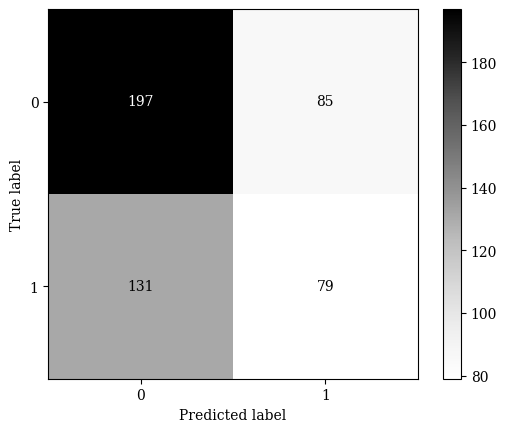

In [400]:
cm = confusion_matrix(b_y.flatten(), predicted.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Greys')
plt.show()

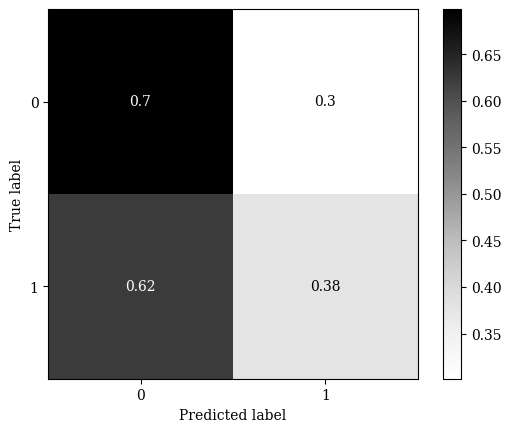

In [401]:
cm = confusion_matrix(b_y.flatten(), predicted.flatten(), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Greys')
plt.show()

## TEST

In [402]:
b_x = np.concatenate([x for x, y in w.test], axis = 0)
b_y = np.concatenate([y for x, y in w.test], axis = 0)

ensemble = []

for i in range(100):
    ensemble.append(bnn(b_x))

mean = np.mean(ensemble, axis = 0)
std = np.std(ensemble, axis = 0)

predicted = np.where(mean > 0.444, 1, 0)

In [403]:
print(accuracy_score(b_y.flatten(), predicted))

0.556910569105691


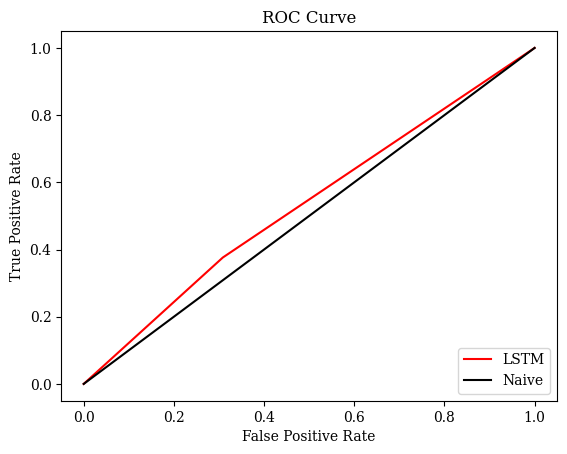

In [404]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(b_y.flatten(), mean)


fig, ax = plt.subplots()

fpr, tpr, thresholds = roc_curve(b_y.flatten(), predicted)
roc_display2 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'Red', ax=ax, label = 'LSTM')
cutoffs = np.linspace(0, 1, 100)
roc_display3 = RocCurveDisplay(fpr=cutoffs, tpr=cutoffs).plot(color = 'Black', ax=ax, label = 'Naive')
plt.title("ROC Curve")
plt.set_cmap('Greys')
plt.show()

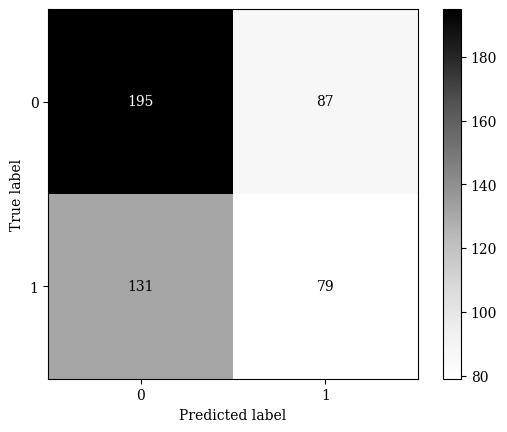

In [405]:
cm = confusion_matrix(b_y.flatten(), predicted.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Greys')
plt.show()

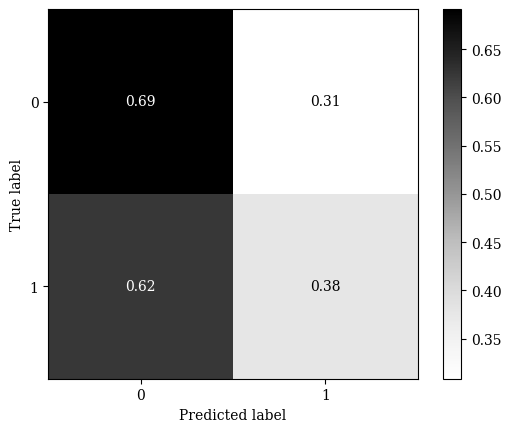

In [406]:
cm = confusion_matrix(b_y.flatten(), predicted.flatten(), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Greys')
plt.show()